In [1]:
#%pip install pandas numpy matplotlib gym stable-baselines3 scikit-learn

In [2]:
#%pip install openpyxl

In [3]:
#%pip install gymnasium

In [4]:
import numpy as np
import pandas as pd
import gymnasium as gym
import gymnasium.spaces as spaces
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
file_path='OnlineRetail.xlsx'

In [6]:
def load_data(file_path):
    """
    Load UCI Online Retail dataset and keep only necessary columns.
    
    Args:
        file_path (str): Path to Excel file.
    
    Returns:
        pd.DataFrame: Filtered DataFrame with StockCode, UnitPrice, Quantity.
    """
    df = pd.read_excel(file_path)
    df = df[['StockCode', 'UnitPrice', 'Quantity']]
    df = df.dropna(subset=['StockCode', 'UnitPrice', 'Quantity'])
    df = df[df['UnitPrice'] > 0]
    df = df[df['Quantity'] > 0]
    return df

df=load_data(file_path)

In [7]:
df.shape

(530104, 3)

In [8]:
df.head()

,StockCode,UnitPrice,Quantity
0,85123A,2.55,6
1,71053,3.39,6
2,84406B,2.75,8
3,84029G,3.39,6
4,84029E,3.39,6


In [9]:
df.shape

(530104, 3)

In [10]:
df['StockCode'].value_counts()

StockCode
85123A    2265
85099B    2112
22423     2017
47566     1706
20725     1595
          ... 
47016        1
85049c       1
84550        1
47591b       1
23843        1
Name: count, Length: 3922, dtype: int64

In [11]:
df['StockCode'].nunique()

3922

In [12]:
# Filter out the top 15 most common StockCodes
top_stockcodes = df['StockCode'].value_counts().nlargest(2).index
df = df[df['StockCode'].isin(top_stockcodes)].copy()

In [13]:
df.shape

(4377, 3)

In [14]:
df['StockCode'].value_counts()

StockCode
85123A    2265
85099B    2112
Name: count, dtype: int64

In [15]:
class DynamicPricingEnv(gym.Env):
    def __init__(self, data, product_id, max_steps=100):
        super(DynamicPricingEnv, self).__init__()
        # Filter dataset for the specific StockCode
        self.data = data[data['StockCode'] == product_id].copy()
        if self.data.empty:
            raise ValueError(f"No data found for product {product_id}")
        
        # Normalize prices to range 0.5–1.5
        self.scaler = MinMaxScaler(feature_range=(0.5, 1.5))
        self.data['UnitPrice'] = self.scaler.fit_transform(self.data[['UnitPrice']])
        
        # Calculate average quantity for demand modeling
        self.avg_quantity = self.data['Quantity'].mean()
        
        # Define action space: 10 discrete price levels
        self.action_space = spaces.Discrete(10)
        
        # Define observation space: [normalized_price, purchase_probability]
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0]),
            high=np.array([2.0, 1.0]),
            dtype=np.float32
        )
        
        self.max_steps = max_steps
        self.current_step = 0
        self.current_price = 1.0
        self.purchase_prob = 0.5
        self.total_revenue = 0.0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.current_price = 1.0
        self.purchase_prob = 0.5
        self.total_revenue = 0.0
        obs = np.array([self.current_price, self.purchase_prob], dtype=np.float32)
        return obs, {}  # observation and empty info dict


    def step(self, action):
        # Map action (0–9) to price multiplier (0.5–1.5)
        price_multiplier = 0.5 + (action / 9.0) * 1.0
        self.current_price = price_multiplier

        # Calculate purchase probability
        price_factor = 0.5 * (self.current_price - 0.5)
        quantity_factor = self.avg_quantity / self.data['Quantity'].max()
        self.purchase_prob = max(0.1, 1.0 - price_factor + 0.1 * quantity_factor)

        # Simulate purchase
        purchase = np.random.random() < self.purchase_prob
        reward = self.current_price * self.avg_quantity * purchase
        self.total_revenue += reward

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False  # No early stop logic for now

        obs = np.array([self.current_price, self.purchase_prob], dtype=np.float32)
        info = {"revenue": self.total_revenue, "purchase_rate": self.purchase_prob}

        return obs, reward, terminated, truncated, info


    def render(self):
        # Print current state for debugging
        print(f"Step: {self.current_step}, Price: {self.current_price:.2f}, "
              f"Purchase Prob: {self.purchase_prob:.2f}, Total Revenue: {self.total_revenue:.2f}")


In [16]:
models = {
    "DQN": (DQN, {
        "policy": "MlpPolicy",
        "learning_rate": 0.001,
        "buffer_size": 10000,
        "batch_size": 32
    }),
    "PPO": (PPO, {
        "policy": "MlpPolicy",
        "learning_rate": 0.0003,
        "n_steps": 2048,
        "batch_size": 64
    })
}


In [17]:
results = {}
stockcode_counts = df['StockCode'].value_counts().reset_index()
stockcode_counts.columns = ['StockCode', 'Count']

# Select the top 5 StockCodes by transaction count
top_stockcodes = stockcode_counts.head(5)

# Extract the list of top 5 StockCodes
selected_stockcodes = top_stockcodes['StockCode'].tolist()

# Display the top 5 StockCodes and their counts
print("\nTop 5 StockCodes by transaction count:")
print(top_stockcodes)
print(f"Selected StockCodes: {selected_stockcodes}")


Top 5 StockCodes by transaction count:
  StockCode  Count
0    85123A   2265
1    85099B   2112
Selected StockCodes: ['85123A', '85099B']


In [18]:
results = {}

# Loop through each StockCode in the top 5
for product_id in selected_stockcodes:
    print(f"\nProcessing StockCode: {product_id}")
    
    # Initialize environment for the current StockCode
    env = DynamicPricingEnv(df, product_id, max_steps=100)
    
    # Train, evaluate, and save each model (DQN, PPO)
    for model_name, (model_class, model_params) in models.items():
        print(f"Training {model_name} for {product_id}...")
        
        # Initialize and train the model
        model = model_class(**model_params, env=env, verbose=0)
        model.learn(total_timesteps=5000)  # Reduced timesteps for efficiency
        
        # Save the trained model
        model_path = f"Training/Saved Models/model_{model_name}_{product_id}.zip"
        model.save(model_path)
        print(f"Saved model to '{model_path}'")
        
        # Evaluate the model
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
        
        # Collect metrics during evaluation and render
        revenues = []
        purchase_rates = []
        actions_taken = []  # Track actions for optimal price
        optimal_prices = []  # To track the optimal price at each step

        obs, _ = env.reset()  # Gymnasium API: returns (obs, info)
        for step in range(env.max_steps):
            action, _ = model.predict(obs)
            actions_taken.append(action)  # Track action
            obs, reward, terminated, truncated, info = env.step(action)  # Gymnasium API: 5 return values
            done = terminated or truncated
            revenues.append(info['revenue'])
            purchase_rates.append(info['purchase_rate'])
            
            # Calculate the optimal price from action (based on your action space)
            optimal_price = 0.5 + (action / 9.0)  # Adjust this formula according to your action space
            optimal_prices.append(optimal_price)

            # Render every 10 steps
            if step % 10 == 0:
                env.render()
            
            if done:
                break

        # Store results with additional metadata
        results[f"{model_name}_{product_id}"] = {
            "stockcode": product_id,
            "model": model_name,
            "mean_reward": mean_reward,
            "std_reward": std_reward,
            "revenues": revenues,
            "purchase_rates": purchase_rates,
            "cumulative_revenue": np.sum(revenues),
            "average_purchase_rate": np.mean(purchase_rates),
            "model_path": model_path,
            "optimal_price": optimal_prices  # Store the prices at each step
        }



Processing StockCode: 85123A
Training DQN for 85123A...


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Saved model to 'Training/Saved Models/model_DQN_85123A.zip'


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Step: 1, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 17.55
Step: 11, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 117.31
Step: 21, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 217.07
Step: 31, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 341.78
Step: 41, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 491.42
Step: 51, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 641.06
Step: 61, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 815.64
Step: 71, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 865.52
Step: 81, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 1015.17
Step: 91, Price: 1.50, Purchase Prob: 0.50, Total Revenue: 1139.87
Training PPO for 85123A...
Saved model to 'Training/Saved Models/model_PPO_85123A.zip'
Step: 1, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 23.09
Step: 11, Price: 1.28, Purchase Prob: 0.61, Total Revenue: 162.57
Step: 21, Price: 1.17, Purchase Prob: 0.67, Total Revenue: 252.18
Step: 31, Price: 0.72, Purchase Prob: 0.89, Total Revenue

c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Saved model to 'Training/Saved Models/model_DQN_85099B.zip'


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Step: 1, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 24.23
Step: 11, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 218.04
Step: 21, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 387.63
Step: 31, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 532.99
Step: 41, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 743.38
Step: 51, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 961.42
Step: 61, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 1096.58
Step: 71, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 1193.49
Step: 81, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 1357.98
Step: 91, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 1503.34
Training PPO for 85099B...
Saved model to 'Training/Saved Models/model_PPO_85099B.zip'
Step: 1, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 24.23
Step: 11, Price: 0.94, Purchase Prob: 0.78, Total Revenue: 164.49
Step: 21, Price: 0.83, Purchase Prob: 0.84, Total Revenue: 293.27
Step: 31, Price: 0.94, Purchase Prob: 0.78, Total Reven

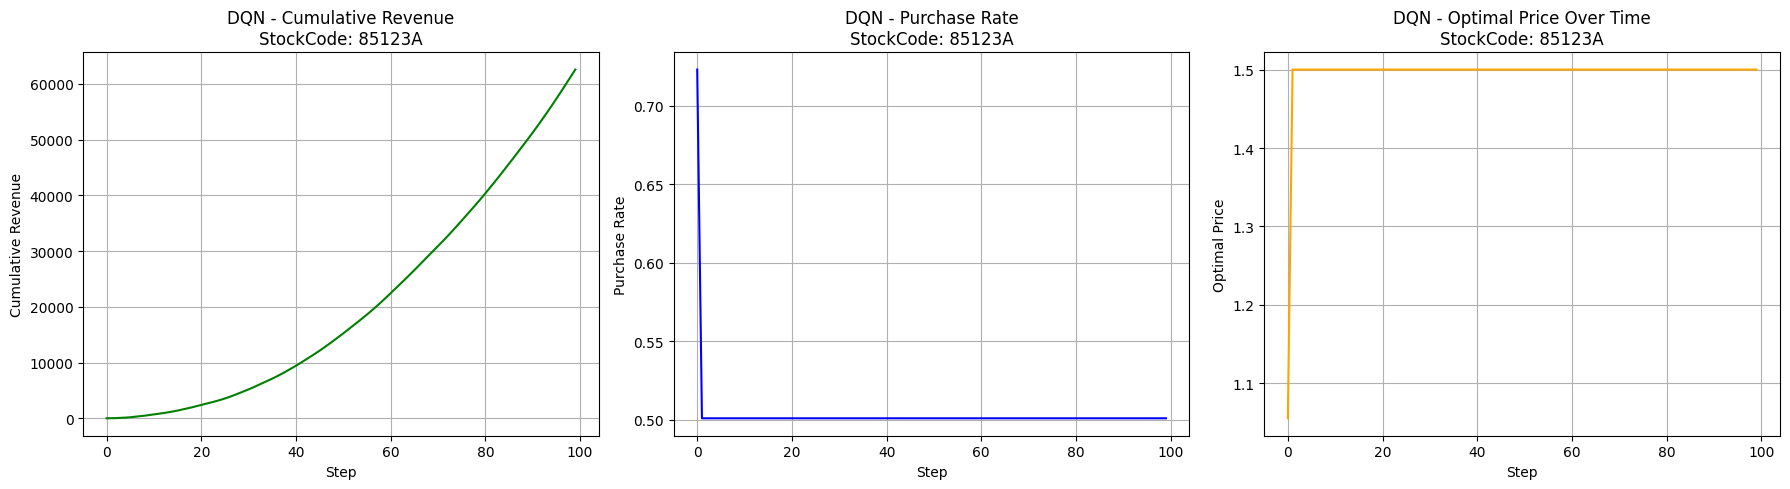

<Figure size 640x480 with 0 Axes>

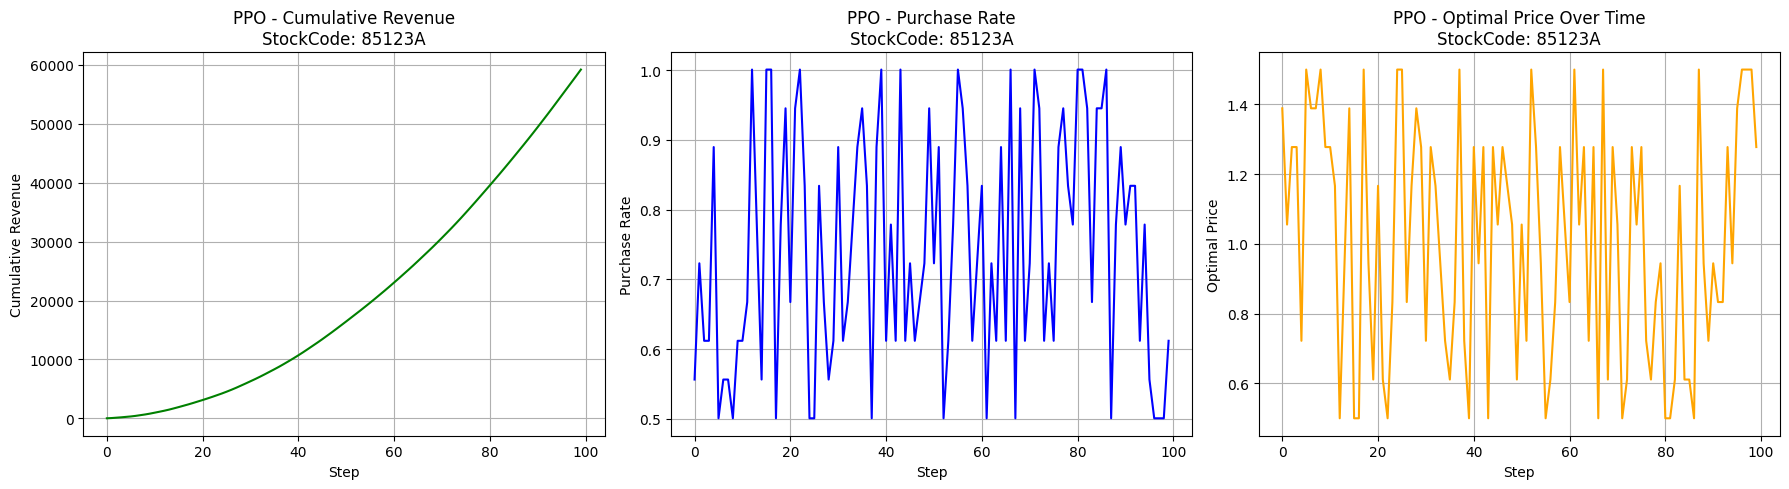

<Figure size 640x480 with 0 Axes>

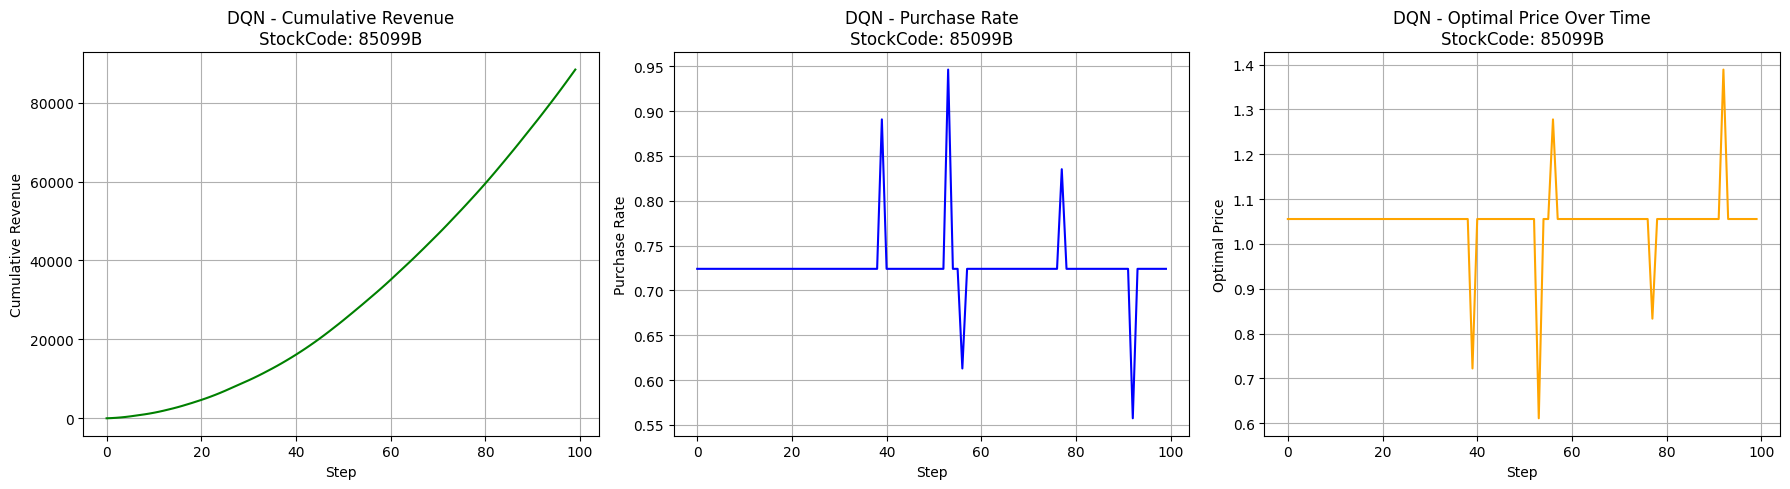

<Figure size 640x480 with 0 Axes>

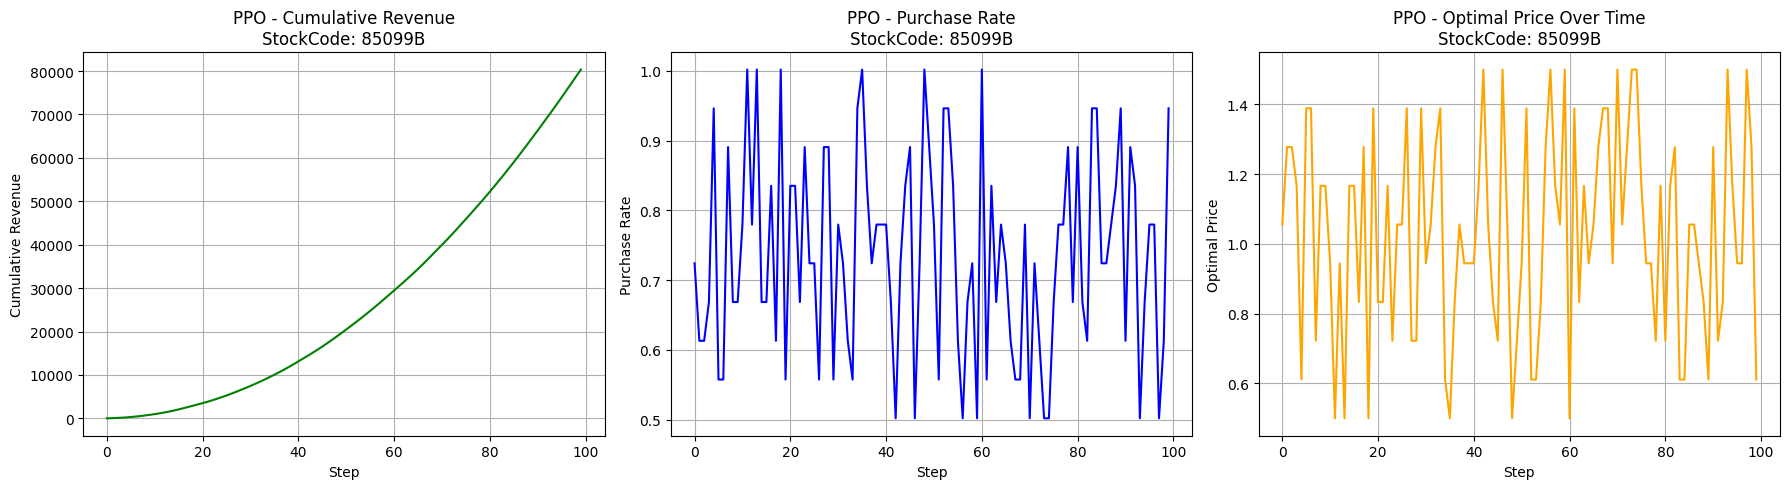

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot 3-in-a-row graphs for each model and StockCode (total 4 figures)
for product_id in selected_stockcodes:
    for model_name in models:
        key = f"{model_name}_{product_id}"
        if key not in results:
            continue

        data = results[key]

        # Create 3 subplots in a row
        plt.figure(figsize=(18, 5))

        # Subplot 1: Cumulative Revenue
        plt.subplot(1, 3, 1)
        plt.plot(np.cumsum(data["revenues"]), color='green')
        plt.title(f"{model_name} - Cumulative Revenue\nStockCode: {product_id}")
        plt.xlabel("Step")
        plt.ylabel("Cumulative Revenue")
        plt.grid(True)

        # Subplot 2: Purchase Rate
        plt.subplot(1, 3, 2)
        plt.plot(data["purchase_rates"], color='blue')
        plt.title(f"{model_name} - Purchase Rate\nStockCode: {product_id}")
        plt.xlabel("Step")
        plt.ylabel("Purchase Rate")
        plt.grid(True)

        # Subplot 3: Optimal Price
        plt.subplot(1, 3, 3)
        plt.plot(data["optimal_price"], color='orange')
        plt.title(f"{model_name} - Optimal Price Over Time\nStockCode: {product_id}")
        plt.xlabel("Step")
        plt.ylabel("Optimal Price")
        plt.grid(True)

        plt.tight_layout()
        plt.show()
        
        #save the figure
        plt.savefig(f"Training/Saved Models/{model_name}_{product_id}_3in1.png")


In [29]:
import pandas as pd

# Create a list to store all rows
evaluation_rows = []

# Collect evaluation metrics
for product_id in selected_stockcodes:
    for model_name in models:
        key = f"{model_name}_{product_id}"
        if key in results:
            mean_reward = results[key]['mean_reward']
            std_reward = results[key]['std_reward']
            total_revenue = np.sum(results[key]['revenues'])
            avg_purchase_rate = np.mean(results[key]['purchase_rates'])
            final_opt_price = results[key]['optimal_price'][-1]
            avg_opt_price = np.mean(results[key]['optimal_price'])

            # Append to rows list
            evaluation_rows.append({
                "StockCode": product_id,
                "Model": model_name,
                "Mean Reward": f"{mean_reward:.2f} ± {std_reward:.2f}",
                "Final Revenue": f"{total_revenue:.2f}",
                "Avg Purchase Rate": f"{avg_purchase_rate:.2f}",
                "Final Optimal Price": f"{final_opt_price:.2f}",
                "Avg Optimal Price": f"{avg_opt_price:.2f}"
            })

# Convert to DataFrame
evaluation_df = pd.DataFrame(evaluation_rows)

# Display the DataFrame
print("\nAggregate Evaluation Metrics Table:")
display(evaluation_df)

# Close the environment
env.close()



Aggregate Evaluation Metrics Table:


,StockCode,Model,Mean Reward,Final Revenue,Avg Purchase Rate,Final Optimal Price,Avg Optimal Price
0,85123A,DQN,1257.00 ± 169.96,62584.69,0.50,1.50,1.50
1,85123A,PPO,1295.98 ± 88.62,59204.81,0.74,1.28,1.01
2,85099B,DQN,1773.40 ± 98.59,88370.44,0.73,1.06,1.05
3,85099B,PPO,1736.30 ± 82.51,80333.52,0.74,0.61,1.03
